In [2]:
import numpy as np
import math
from tqdm.notebook  import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
rcut = 3.0  ##### Cut-off distance. If distance between atoms is greater than this, interaction between them is ignored.
rcutsquare = rcut**2
g2 = 1./rcutsquare
g6 = g2*g2*g2
potcut = 4.*g6*(g6-1) ##### Term to be subtracted from pair potential energy

In [4]:
##### Function to compute acceleration for a pair of atoms. r12 is relative displacement of atoms.

def acceleration(r12): 
    r12square = np.dot(r12,r12)
    f2 = 1./r12square
    f6 = f2*f2*f2
    acc = 48.*f2*f6*(f6-0.5)*r12
    return acc


In [5]:
#### Function to compute potential energy for the system of particles. `pos' is the array of position vectors.
def potentialenergy(pos):
    potential = 0.
    for i in range(Natoms-1): 
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j] ## Relative position vector of the pair
            for l in range(2):  ### Calculating the correct separation between particles because of periodic boundary conditions.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            rijsquare = np.dot(rij,rij)
            if rijsquare < rcutsquare: # Imposing interaction cut-off
                f2 = 1./rijsquare
                f6 = f2*f2*f2
                potential += 4.*f6*(f6-1.) - potcut
    return potential

In [20]:
def create_picture(positions):
    plt.cla()
    plt.gca().set_aspect('equal')
    plt.axis([0, L, 0, L])
    plt.setp(plt.gca(), xticks=[0, L], yticks=[0, L])
    for x,y in positions:
        atom = plt.Circle((x, y), Ratom, fc='r')
        plt.gca().add_patch(atom)

In [7]:
def RDF(pos,length):
    dist = [0 for i in range(length)]
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j] ## Relative position vector of the pair
            for l in range(2):  ### Calculating the correct separation between particles because of periodic boundary conditions.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            rijsquare = np.dot(rij,rij)
            r = np.sqrt(rijsquare)
            nbin = math.floor(r/delta)
            if nbin<= length - 1:
                dist[nbin] += 1
    for i in range(length):
        r = delta*(i + 1/2)
        dist[i] = dist[i]/(rho * 2* math.pi * r* delta)
    dist = np.array(dist)
    return dist

In [8]:
number = 7
Natoms = number**2  # No. of atoms
Ratom = 0.35  ### Radius of atom used to illustrate the atom as a sphere.
rho = 0.25 ### Number Density
L = math.pow(Natoms/rho,0.5) # Length of a side of the square containing the gas.
T0 = 120. # Natural temperature scale, T0 = epsilon/k.
T = 2.6 # Desired temperature
K0 = Natoms * T
Treal = 1 #real tempearature in Kelvin
dt = 1E-2  # Time step for Verlet Algorithm

In [9]:
delta = 0.1
length = int(0.5 * L/0.1)
rho = Natoms/(L*L)

In [10]:
###### Atoms are arranged initially in a square lattice configuration with spacing between neighbors equal to equilibrium separation of the potential energy.

equilib_sep = math.pow(2.,1./6.)  ## Equilibrium separation of atoms
wall_spacing = (L-(number-1)*equilib_sep)/2.  ## Distance betwee the walls and the initial array of atoms.
poslist = []  # List for positions of atoms
vlist = []   # List for velocities


################  Initialize positions and velocities ##############################################
x, y = wall_spacing, wall_spacing
for i in range(number):
    for j in range(number):
        xi, yi = x + equilib_sep*i, y + equilib_sep*j
        poslist.append((xi,yi))


####### Initially, all particles have the same speed but random velocity directions. ################
v0 = math.sqrt(2.*Treal/T0)

for i in range(Natoms):
    phi = 2*np.pi*np.random.random()
    vx = v0*np.cos(phi)
    vy = v0*np.sin(phi)
    vlist.append((vx,vy))
###################################################################################################




pos = np.array(poslist)  ### Converts lists to numpy arrays
v = np.array(vlist) ## Scaled velocity


V_cm = np.sum(v, axis = 0)/Natoms ## Correcting for CM velocity.
V = np.array([V_cm,]*Natoms)
v -= V  

print(np.square(v).sum(axis =1))

[0.01392233 0.01500487 0.01688391 0.01799339 0.0198083  0.01476628
 0.01968406 0.0172114  0.01426288 0.01453843 0.01431321 0.01980139
 0.01740748 0.01451211 0.01367871 0.017254   0.01795289 0.01823677
 0.01386529 0.01984293 0.01514506 0.01762004 0.01372556 0.01371417
 0.01438433 0.01947392 0.01629153 0.0137068  0.01828154 0.01381294
 0.01439127 0.01905472 0.01473827 0.0165036  0.01725628 0.01752756
 0.01561351 0.0198259  0.01896484 0.01993244 0.01761236 0.01409768
 0.01405317 0.0186972  0.01989794 0.01752983 0.01836073 0.01374407
 0.0145431 ]


In [11]:
time = 0. # Initial time.
t_final = 50. # Time upto which simulation is carried out.

potential_energy = potentialenergy(pos)
kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))
energy = kinetic_energy + potential_energy
Time_List = [time]
Energy_List = [energy]
PotentialEnergy_List = [potential_energy]
KineticEnergy_List = [kinetic_energy/Natoms]

###################rescaling KEs#############################
avg_ke = kinetic_energy/Natoms
lamb = (K0/kinetic_energy)**0.5
v = v * lamb
#############################################################
iterations = int(t_final/dt) # Number of iterations of the Verlet Algorithm.

In [12]:
##################################### The Verlet Algorithm Loop ###################################
pvels = []
for step in tqdm(range(iterations)):
    pos += v*dt/2. ## Updating positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L
            elif pos[i][j] < 0: pos[i][j] += L
                
                
    accel = np.zeros((Natoms,2)) ## Initialising acceleration array.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j]
            for l in range(2):  ### Calculating the correct separation between particles.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            if np.dot(rij,rij) < rcutsquare:
                acc = acceleration(rij) # Computing acceleration for a pair of particles.
                accel[i] += acc
                accel[j] -= acc
    v += accel*dt  ## Updating velocities.
    pos += v*dt/2. ## Final updating of positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L
            elif pos[i][j] < 0: pos[i][j] += L
    potential_energy = potentialenergy(pos)
    kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))
    KineticEnergy_List.append(kinetic_energy/Natoms)
    energy = kinetic_energy + potential_energy
    Energy_List.append(energy)
    PotentialEnergy_List.append(potential_energy)
    time += dt
    Time_List.append(time)
    #############################################################
    if time >= 10.0:
        pvel = np.square(v).sum(axis = 1)
        pvel = pvel**0.5
        #print(pvel)
        pvels += pvel.tolist()
    ###################rescaling KEs#############################
    lamb = np.sqrt(K0/kinetic_energy)
    v = v * lamb   

  0%|          | 0/5000 [00:00<?, ?it/s]

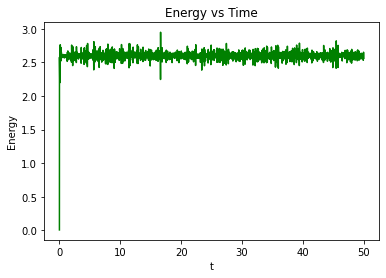

In [13]:
plt.xlabel('t') # Label for the x-axis
plt.ylabel('Energy') # Label for the y-axis
plt.title('Energy vs Time') # Title of plot
#plt.plot(Time_List,Energy_List, color = 'r') 
#plt.plot(Time_List,PotentialEnergy_List, color = 'b')
plt.plot(Time_List,KineticEnergy_List, color = 'g')

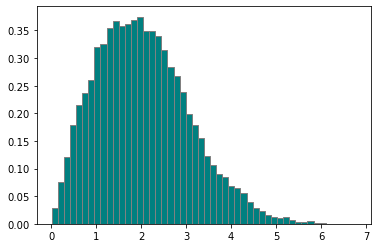

In [14]:
n_bins = 50
plt.hist(pvels, bins = n_bins, density=True, color='teal', edgecolor='grey');

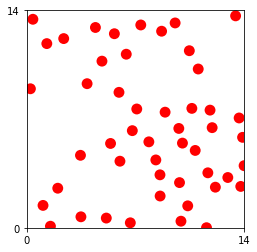

In [15]:
create_picture(pos)

In [16]:
time = 0. # Initial time.
t_final = 200. # Time upto which simulation is carried out.
dt = 1E-2
iterations = int(t_final/dt) # Number of iterations of the Verlet Algorithm.
samples = 0
dist = [0 for i in range(length)]
dist = np.array(dist)

for step in tqdm(range(iterations)):
    pos += v*dt/2. ## Updating positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L
            elif pos[i][j] < 0: pos[i][j] += L
                
                
    accel = np.zeros((Natoms,2)) ## Initialising acceleration array.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j]
            for l in range(2):  ### Calculating the correct separation between particles.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            if np.dot(rij,rij) < rcutsquare:
                acc = acceleration(rij) # Computing acceleration for a pair of particles.
                accel[i] += acc
                accel[j] -= acc
    v += accel*dt  ## Updating velocities.
    pos += v*dt/2. ## Final updating of positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L
            elif pos[i][j] < 0: pos[i][j] += L
    potential_energy = potentialenergy(pos)
    kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))
    KineticEnergy_List.append(kinetic_energy/Natoms)
    energy = kinetic_energy + potential_energy
    Energy_List.append(energy)
    PotentialEnergy_List.append(potential_energy)
    time += dt
    Time_List.append(time)
    if time > 100.0:
        if step%10 == 0:
            samples+= 1
            dist1 = RDF(pos,length)
            dist = dist + dist1


  0%|          | 0/20000 [00:00<?, ?it/s]

In [17]:
dist = dist/samples
lengths = [(i + 1/2)*delta for i in range(length)]

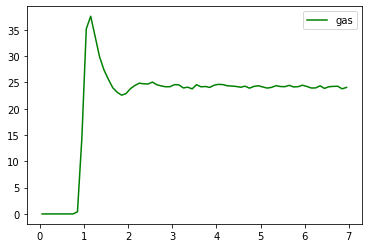

In [18]:
plt.plot(lengths, dist, color = 'g', label = 'gas')
plt.legend()

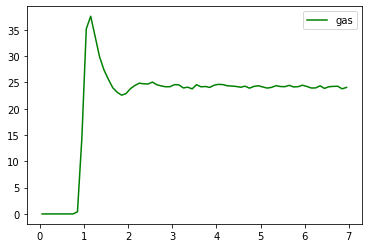

In [19]:
plt.plot(lengths, dist, color = 'g', label = 'gas')
plt.legend()